In [1]:
from glob import glob
from itertools import combinations
from multiprocessing import Pool
import subprocess

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist, squareform

In [13]:
def get_dist(pair):
    x, y = pair
    if x == y:
        return 1.0
    lines = (
        subprocess.run(
            [
                "/runs/users/vv137/bin/USalign",
                "-outfmt",
                "2",
                x,
                y,
            ],
            stdout=subprocess.PIPE,
        )
        .stdout.decode()
        .splitlines()
    )
    line = lines[1]
    return float(line.split()[3])  # TM1

In [14]:
pdbs = []
pdbs.extend(glob(r"../out/H0215/AF0/relaxed_*.pdb"))
pdbs.extend(glob(r"../out/H0215/AF1/relaxed_*.pdb"))
pdbs.extend(glob(r"../out/H0215/NP0/relaxed_*.pdb"))
pdbs.extend(glob(r"../out/H0215/C2M/relaxed_*.pdb"))
pdbs.extend(glob(r"../out/H0215/CPM/relaxed_*.pdb"))

for x in pdbs:
    print(x)
print(len(pdbs))

../out/H0215/AF0/relaxed_model_1_v3.pdb
../out/H0215/AF0/relaxed_model_5_v2.pdb
../out/H0215/AF0/relaxed_model_3_v2.pdb
../out/H0215/AF0/relaxed_model_1_v2.pdb
../out/H0215/AF0/relaxed_model_2_v2.pdb
../out/H0215/AF0/relaxed_model_4_v3.pdb
../out/H0215/AF0/relaxed_model_5_v3.pdb
../out/H0215/AF0/relaxed_model_3_v3.pdb
../out/H0215/AF0/relaxed_model_2_v3.pdb
../out/H0215/AF0/relaxed_model_4_v2.pdb
../out/H0215/C2M/relaxed_model_1_v3.pdb
../out/H0215/C2M/relaxed_model_5_v2.pdb
../out/H0215/C2M/relaxed_model_3_v2.pdb
../out/H0215/C2M/relaxed_model_1_v2.pdb
../out/H0215/C2M/relaxed_model_2_v2.pdb
../out/H0215/C2M/relaxed_model_4_v3.pdb
../out/H0215/C2M/relaxed_model_5_v3.pdb
../out/H0215/C2M/relaxed_model_3_v3.pdb
../out/H0215/C2M/relaxed_model_2_v3.pdb
../out/H0215/C2M/relaxed_model_4_v2.pdb
../out/H0215/CPM/relaxed_model_1_v3.pdb
../out/H0215/CPM/relaxed_model_5_v2.pdb
../out/H0215/CPM/relaxed_model_3_v2.pdb
../out/H0215/CPM/relaxed_model_1_v2.pdb
../out/H0215/CPM/relaxed_model_2_v2.pdb


In [23]:
scores = {}
with open("/gpfs/deepfold/casp/casp16/H0215/scores", "r") as fp:
    lines = fp.readlines()
for line in lines:
    line = line.replace("recycle_", "relaxed_").replace("/frame_20.pdb", "").replace(":REMARK", "")
    sp = line.split()
    name = sp[0]
    conf = float(sp[6].split("=")[1])
    scores[name] = conf

scores

{'AF0/relaxed_model_1_v2': 0.358,
 'AF0/relaxed_model_1_v3': 0.37,
 'AF0/relaxed_model_2_v2': 0.243,
 'AF0/relaxed_model_2_v3': 0.308,
 'AF0/relaxed_model_3_v2': 0.248,
 'AF0/relaxed_model_3_v3': 0.228,
 'AF0/relaxed_model_4_v2': 0.259,
 'AF0/relaxed_model_4_v3': 0.243,
 'AF0/relaxed_model_5_v2': 0.22,
 'AF0/relaxed_model_5_v3': 0.247,
 'AF1/relaxed_model_1_v2': 0.454,
 'AF1/relaxed_model_1_v3': 0.453,
 'AF1/relaxed_model_2_v2': 0.223,
 'AF1/relaxed_model_2_v3': 0.279,
 'AF1/relaxed_model_3_v2': 0.242,
 'AF1/relaxed_model_3_v3': 0.237,
 'AF1/relaxed_model_4_v2': 0.679,
 'AF1/relaxed_model_4_v3': 0.255,
 'AF1/relaxed_model_5_v2': 0.237,
 'AF1/relaxed_model_5_v3': 0.248,
 'C2M/relaxed_model_1_v2': 0.326,
 'C2M/relaxed_model_1_v3': 0.499,
 'C2M/relaxed_model_2_v2': 0.221,
 'C2M/relaxed_model_2_v3': 0.299,
 'C2M/relaxed_model_3_v2': 0.244,
 'C2M/relaxed_model_3_v3': 0.235,
 'C2M/relaxed_model_4_v2': 0.384,
 'C2M/relaxed_model_4_v3': 0.286,
 'C2M/relaxed_model_5_v2': 0.219,
 'C2M/relaxed_mo

In [24]:
pairs = list(combinations(pdbs, 2))
len(pairs)

435

In [30]:
pool = Pool(processes=32)
dist = pool.map(get_dist, pairs)
dist = np.asarray(dist)
dist = 1.0 - dist
dij = squareform(dist)
z = ward(dist)
cluster = fcluster(z, t=0.03, criterion="distance")
uniq = np.unique(cluster)

for k in range(1, len(uniq) + 1):
    mask = cluster == k
    nn = np.sum(mask)

    print(f"cluster={k:<3} size={nn}")
    members = [p.replace("../out/H0215/", "").replace(".pdb", "") for m, p in zip(mask, pdbs) if m]
    m2s = [(m, scores.get(m, 0.0)) for m in members]
    m2s.sort(key=lambda x: x[1], reverse=True)
    print(m2s[0][1], " ".join(m for m, _ in m2s))
print("Total", len(uniq), "clusters")

cluster=1   size=5
0.644 CPM/relaxed_model_4_v2 C2M/relaxed_model_4_v2 AF0/relaxed_model_1_v2 AF0/relaxed_model_4_v2 AF0/relaxed_model_3_v3
cluster=2   size=5
0.499 C2M/relaxed_model_1_v3 AF0/relaxed_model_1_v3 CPM/relaxed_model_5_v2 AF0/relaxed_model_5_v2 C2M/relaxed_model_5_v2
cluster=3   size=2
0.274 CPM/relaxed_model_1_v3 AF0/relaxed_model_5_v3
cluster=4   size=17
0.308 AF0/relaxed_model_2_v3 CPM/relaxed_model_1_v2 C2M/relaxed_model_2_v3 C2M/relaxed_model_4_v3 CPM/relaxed_model_2_v3 CPM/relaxed_model_2_v2 CPM/relaxed_model_4_v3 CPM/relaxed_model_3_v2 AF0/relaxed_model_3_v2 CPM/relaxed_model_5_v3 C2M/relaxed_model_3_v2 AF0/relaxed_model_2_v2 AF0/relaxed_model_4_v3 C2M/relaxed_model_3_v3 C2M/relaxed_model_5_v3 C2M/relaxed_model_2_v2 CPM/relaxed_model_3_v3
cluster=5   size=1
0.326 C2M/relaxed_model_1_v2
Total 5 clusters


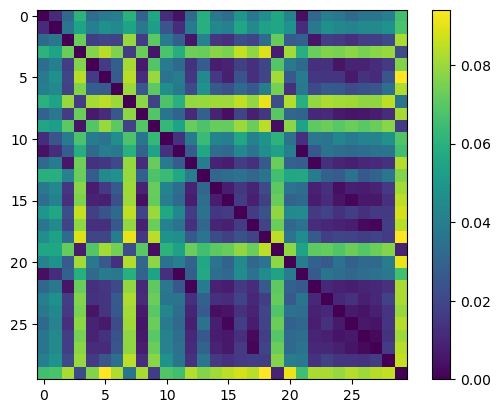

In [28]:
plt.imshow(dij)
plt.colorbar()